In [1]:
######## Packages ########
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

## 変分推論
例として，2次元ガウス分布に対する変分推論を行う．
$$
p(z_1, z_2 \, | \, \mu_1, \mu_2, \Lambda) =
  \mathcal{N}\left( \left. \left(
              \begin{array}{c}
                  z_1 \\
                  z_2
              \end{array}
          \right) \right| \left(
              \begin{array}{c}
                  \mu_1 \\
                  \mu_2
              \end{array}
          \right), \left(
                  \begin{array}{cc}
                      \Lambda_{11} & \Lambda_{12} \\
                      \Lambda_{21} & \Lambda_{22}
                  \end{array}
              \right)^{-1}\right)
$$
に対して，近似分布$q(z_1), q(z_2)$は以下で与えられる (導出は```./Chapter4.2.2.pdf```)．

$$
q(z_1) = \mathcal{N}\left(z_1 \left| \hat{\mu}_1, \Lambda_{11}^{-1}\right. \right)
$$
ただし，
$$
\hat{\mu}_1 = \langle z_1 \rangle = \mu_1 - \Lambda_{11}^{-1}\Lambda_{12}(\langle z_2 \rangle - \mu_2)
$$
および，
$$
q(z_2) = \mathcal{N}\left(z_2 \left| \hat{\mu}_2, \Lambda_{22}^{-1}\right. \right)
$$
ただし，
$$
\hat{\mu}_2 = \langle z_2 \rangle = \mu_2 - \Lambda_{22}^{-1}\Lambda_{12}(\langle z_1 \rangle - \mu_1)
$$

これをもとに変分推論を行う．

In [2]:
#################### real ####################
dim = 2
mu_real = np.zeros(dim)
sigma_real = np.array([
    [1.0, -0.5], 
    [-0.5, 1.0]
])
##############################################

In [3]:
############### Variation inference ###############
def variational_norm(m_init, mu, Sigma, maxitr):
    Mean_list = [m_init]
    dim_list = range(len(m_init))
    for roop in range(maxitr):
        currentm = Mean_list[-1].tolist()
        ############## update m1 and m2 ##############
        for i in dim_list:
            key = list(set(dim_list) - {i})[0]
            currentm[i] = mu[i] - Sigma[i][i]**(-1)*Sigma[i][key]*(currentm[key] - mu[key])
        ##############################################
        Mean_list.append(np.array(currentm))
    return np.array(Mean_list)
###################################################

############### KL divergence ###############
def KL_div_norm(mu, mu_hat, Sigma, Sigma_hat, dim):
    vec = mu - mu_hat
    Mat = (vec @ vec.T + Sigma_hat) @ np.linalg.inv(Sigma)
    trace_term = np.trace(Mat)
    (sign_1, logdet1) = np.linalg.slogdet(Sigma)
    (sign_2, logdet2) = np.linalg.slogdet(Sigma_hat)
    log_term = sign_1*logdet1 - sign_2*logdet2
    kl = (trace_term + log_term - dim)/2
    return kl 
##############################################

In [4]:
############### execute Variation inference ###############
maxitr = 20
m_init = np.array([-1.5, -1])
Mean_array = variational_norm(m_init=m_init, mu=mu_real, Sigma=sigma_real, maxitr=maxitr)
###########################################################

In [5]:
# real distribution
z1, z2 = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))
pos = np.dstack((z1, z2))
norm_pdf_real = stats.multivariate_normal(mu_real, sigma_real).pdf(pos)

# approximate distribution
sigma_approx = np.array([
    [sigma_real[0][0], 0],
    [0, sigma_real[1][1]]
])
approximate_pdf_list = []
for mu in Mean_array:
    pdf = stats.multivariate_normal(mu, sigma_approx).pdf(pos)
    approximate_pdf_list.append(pdf)

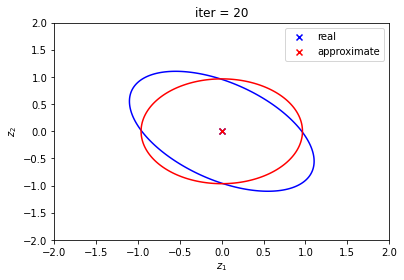

In [6]:
### plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_func(frame):
    ax.clear()
    ax.set_xlabel(r"$z_1$"); ax.set_ylabel(r"$z_2$")
    ### real
    cont_real = ax.contour(z1, z2, norm_pdf_real, levels = [0.1], colors = 'blue')
    ax.scatter(mu_real[0], mu_real[1], marker='x', color = 'blue', label = 'real')  # mean
    ###
    ### approximate
    cont_approx = ax.contour(z1, z2, approximate_pdf_list[frame], levels = [0.1], colors = 'red')
    ax.scatter(Mean_array[frame][0], Mean_array[frame][1], marker = 'x', color = 'red', label = 'approximate')
    ###
    ax.set_title("iter = {}".format(frame))
    ax.legend(loc = 'best')

ani = animation.FuncAnimation(fig, update_func, frames = len(Mean_array), interval = 200)

HTML(ani.to_jshtml())

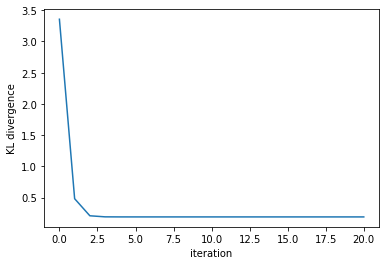

In [7]:
kl_list = []
for i in range(len(Mean_array)):
    kl = KL_div_norm(mu=mu_real.reshape(dim, 1), mu_hat=Mean_array[i].reshape(dim, 1), Sigma=sigma_real, Sigma_hat=sigma_approx, dim=dim)
    kl_list.append(kl)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("iteration"); ax.set_ylabel("KL divergence")
ax.plot(kl_list)
plt.show()